In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_chroma langchain_core langchain_community chromadb pypdf fpdf textblob langchain-tavily transformers torch

In [2]:
%%capture --no-stderr
%%python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


In [13]:
import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

import sqlite3
from typing import Annotated, TypedDict, Dict, Literal, Any
from operator import add
from functools import partial
from random import random
from datetime import datetime

from IPython.display import Image, display
from google.colab import userdata

from langchain_chroma import Chroma
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase
from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    HumanMessage,
    SystemMessage,
)
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings

from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_tavily import TavilySearch
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer

#connect to SQLite DB
conn = sqlite3.connect('hotel.db')
cursor = conn.cursor()

# Create the rooms table
cursor.execute('''
CREATE TABLE IF NOT EXISTS rooms (
  room_number INTEGER PRIMARY KEY,
  room_type TEXT NOT NULL,
  price REAL NOT NULL,
  max_capacity INTEGER NOT NULL,
  amenities TEXT
)
''')

# Create the reservations table
cursor.execute('''
CREATE TABLE IF NOT EXISTS reservations (
  reservation_id INTEGER PRIMARY KEY AUTOINCREMENT,
  guest_name TEXT NOT NULL,
  room_number INTEGER NOT NULL,
  start_date DATE NOT NULL,
  end_date DATE NOT NULL,
  FOREIGN KEY (room_number) REFERENCES rooms(room_number)
)
''')


# Example data for rooms
rooms_data = [
  (101, 'Single', 100, 1, 'TV, Wi-Fi'),
  (102, 'Double', 150, 2, 'TV, Wi-Fi, Balcony'),
  (103, 'Suite', 250, 3, 'TV, Wi-Fi, Balcony, Jacuzzi'),
  (104, 'Deluxe', 200, 2, 'TV, Wi-Fi, Mini-bar'),
  (105, 'Family Suite', 300, 4, 'TV, Wi-Fi, Balcony, Kitchenette'),
  (106, 'Executive Suite', 350, 2, 'TV, Wi-Fi, Balcony, Jacuzzi, City View'),
  (107, 'Double', 150, 2, 'TV, Wi-Fi'),
  (108, 'Deluxe', 200, 2, 'TV, Wi-Fi, Balcony, Fireplace')
]

# Insert the data
cursor.executemany('INSERT OR IGNORE INTO rooms VALUES (?, ?, ?, ?, ?)', rooms_data)

reservations_data = [
    ('Alice Smith', 102, '2025-03-15', '2025-03-18'),
    ('Bob Johnson', 105, '2025-04-22', '2025-04-25'),
    ('Charlie Brown', 106, '2025-06-10', '2025-06-12')
]

# Insert the data
cursor.executemany('INSERT INTO reservations (guest_name, room_number, start_date, end_date) VALUES (?, ?, ?, ?)', reservations_data)

conn.commit()
conn.close()
print("Database initialized successfully.")

# initialize the memory saver
memory = MemorySaver()

# Create an instance of LLM of your choice
llm = ChatOpenAI(model="gpt-4o-mini", api_key=userdata.get('OPENAI_API_KEY'),
                      temperature=0)


# define our db as a set of sql tools
db = SQLDatabase.from_uri("sqlite:///hotel.db")
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
sql_tools = toolkit.get_tools()

# write compliance rules to the file and read it back
with open('compliance.txt', 'w') as file:
    file.write('The system should refuse or redirect queries with:')
    file.write('Illegal requests (e.g., falsifying documents, fraudulent bookings).')
    file.write('Hate speech, harassment, or explicit threats toward individuals or groups.')
    file.write('Offensive, obscene, or otherwise harmful content.')
    file.write('Request of information about other guests. You cannot share there names or dates of stay')

with open('compliance.txt', 'r') as file:
    content = file.read()

# Set up OpenAI embeddings
embedding_function = OpenAIEmbeddingFunction(
    api_key=userdata.get('OPENAI_API_KEY'),
    model_name="text-embedding-ada-002"  # OpenAI's ada embeddings
)

# Initialize Chroma client with OpenAI embedding function
client = chromadb.Client()
collection = client.create_collection(
    name="compliance_rules",
    embedding_function=embedding_function
)

# Add documents to Chroma DB
collection.add(
    documents=[content],
    ids=["compliance_rules"]
)

print("VectorStore initialized successfully.")

# Set up OpenAI embeddings
openai_embeddings = OpenAIEmbeddings(model="text-embedding-ada-002", openai_api_key=userdata.get('OPENAI_API_KEY'))

# Connect LangChain with your Chroma collection
vectorstore = Chroma(
    client=client,
    collection_name="compliance_rules",
    embedding_function=openai_embeddings
)

# create a custom tool
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vectorstore.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

rag_tools = [retrieve]

print("VectorStore connected to LangGraph successfully.")

# create a custom tool
@tool(response_format="content")
def get_sentiment(query: str):
    """Get the sentiment of a query."""

    sentiment_1 = TextBlob(query, analyzer=PatternAnalyzer()).sentiment.polarity
    sentiment_2 = TextBlob(query, analyzer=NaiveBayesAnalyzer()).sentiment.p_neg

    if (sentiment_1 < -0.3) or (sentiment_2 > 0.6):
        sentiment = "Negative"
    else:
        sentiment = "Positive"

    return sentiment


sentiment_tools = [get_sentiment]

print("Sentiment Analysis Tool loaded successfully.")

search_tool = TavilySearch(
    max_results=5,
    topic="general",
    tavily_api_key=userdata.get('TAVILY_API_KEY')
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
)

print("Web Search Tool loaded successfully.")

Database initialized successfully.


UniqueConstraintError: Collection compliance_rules already exists

In [3]:
from transformers import MarianMTModel, MarianTokenizer

# Specify the models
de_en_model_name = "Helsinki-NLP/opus-mt-de-en"
en_de_model_name = "Helsinki-NLP/opus-mt-en-de"

# Load the tokenizers and models
tokenizer_de_en = MarianTokenizer.from_pretrained(de_en_model_name)
model_de_en = MarianMTModel.from_pretrained(de_en_model_name)

tokenizer_en_de = MarianTokenizer.from_pretrained(en_de_model_name)
model_en_de = MarianMTModel.from_pretrained(en_de_model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [4]:
# Define the source text
text_source_en = ["Hello, I want to book a room in your hotel"]
# Tokenize the source text
inputs_en = tokenizer_en_de(text_source_en, return_tensors="pt", padding=True)
# Generate the translation
de_translated = model_en_de.generate(**inputs_en)
# Decode the translated text
text_translated_de = [tokenizer_en_de.decode(t, skip_special_tokens=True) for t in de_translated]
print(text_translated_de)

['Hallo, ich möchte ein Zimmer in Ihrem Hotel buchen']


In [5]:
text_source_de = ["Hallo, wie lange ist der Empfang heute geöffnet?"]
inputs_de = tokenizer_de_en(text_source_de, return_tensors="pt", padding=True)
en_translated = model_de_en.generate(**inputs_de)
text_translated_en = [tokenizer_de_en.decode(t, skip_special_tokens=True) for t in en_translated]
print(text_translated_en)

['Hello, how long is the reception open today?']


In [6]:
from transformers import pipeline

text = [
    "Hello, I want to book a room in your hotel",
    "Hallo, wie lange ist der Empfang heute geöffnet?"
]

model_ckpt = "papluca/xlm-roberta-base-language-detection"
pipe = pipeline("text-classification", model=model_ckpt)
pipe(text, top_k=1, truncation=True)

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

(…)6de7952f7c11ab059eca145a0a727afce0db2865:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


[[{'label': 'en', 'score': 0.9920669794082642}],
 [{'label': 'de', 'score': 0.9951110482215881}]]

In [15]:
def translation_service(query: str, target_language: Literal["en", "de"] = "en") -> Dict[str, Any]:
    """
      A tool to translate user requests to english and back
    """

    odel_ckpt = "papluca/xlm-roberta-base-language-detection"
    pipe = pipeline("text-classification", model=model_ckpt)
    language = pipe(query, top_k=1, truncation=True)
    source_languge = language[0]["label"]

    if (source_languge == "en") and (target_language == "de"):
      model_name = "Helsinki-NLP/opus-mt-en-de"
      tokenizer = MarianTokenizer.from_pretrained(model_name)
      model = MarianMTModel.from_pretrained(model_name)
      inputs = tokenizer(query, return_tensors="pt", padding=True)
      translated = model.generate(**inputs)
      query_other = [tokenizer.decode(t, skip_special_tokens=True) for t in translated][0]
      query_en = query

    elif (source_languge == "de") and (target_language == "en"):
      model_name = "Helsinki-NLP/opus-mt-de-en"
      tokenizer = MarianTokenizer.from_pretrained(model_name)
      model = MarianMTModel.from_pretrained(model_name)
      inputs = tokenizer(query, return_tensors="pt", padding=True)
      translated = model.generate(**inputs)
      query_other = query
      query_en = [tokenizer.decode(t, skip_special_tokens=True) for t in translated][0]

    else:
      query_other = query
      query_en = query


    return {"english_version": query_en, "original_version": query_other, "source_language": source_languge}

In [17]:
from typing import Annotated, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# bind LLM with tools
llm_with_sql_tools = llm.bind_tools(tools=sql_tools)
llm_with_rag_tools = llm.bind_tools(tools=rag_tools)
llm_with_sentiment_tools = llm.bind_tools(tools=sentiment_tools)
llm_with_search_tools = llm.bind_tools(tools=[search_tool])

user_language = "en"

# System message for conversational agent
sys_msg_conversation = SystemMessage(content="""

  Role: You are the Conversation Coordinator for a hotel chain’s customer support system.
  Your role is to manage the flow of the conversation with the guest and decide whether to handle the request yourself or forward the conversation to the next agent based on the user’s needs.

  Primary Tasks:

  Engage with the user: Start the conversation politely and ask how you can assist them.
  Identify the nature of the request: Listen to the guest’s inquiry and determine if it’s a general question, booking-related, issue resolution, or any other category that might require specialized handling.
  Route the conversation if necessary: If the request requires expertise outside your scope, forward it to a specialized agent by answering with the name of the corresponding agent. There are the following agents available:

  - reservation_assistant;
  - compliance_checker;
  - web_search_assistant;

  Maintain a friendly and helpful tone: Always aim for a customer-friendly and empathetic response. Ensure the guest feels heard and cared for.

  Guidelines:

  - If the sentiment of the users query is negative please ask how you can help to handle the situation.
  - First you need to forward every query to compliance checker. If it violates any rule then do not respond, otherwise respond yourself or forward the query to the next agent.
  - If user asks about the information that can be found in the internet like points of interests, forward the query to the web_search_assistant. Also provide any required information, like the adress of the hotel.
  - For general inquiries (e.g., facilities, amenities, location details), assist the user directly.
  - If user wants to book a room. The following information: room type, required dates. Only if user has provided this information forward to the reservation_assistant otherwise do not mention reservation_assistant.
  - If the final answer is not translated to guest's language please forward to the translator-

   Additional Inforamtion:

   The hotel is located here: 36 W 106th St, New York, NY 10025, United States.

   """)

# System message for sql-based reservation agent
sys_msg_sql = SystemMessage(content="""

  You are AI assistant specialized in SQL. You have access to the following database schema:

  Table: rooms
    room_number (INTEGER PRIMARY KEY)
    room_type (TEXT NOT NULL)
    price (REAL NOT NULL)
    max_capacity (INTEGER NOT NULL)
    amenities (TEXT)

  Table: reservations
    reservation_id (INTEGER PRIMARY KEY AUTOINCREMENT)
    guest_name (TEXT NOT NULL)
    room_number (INTEGER NOT NULL, FOREIGN KEY REFERENCES rooms(room_number))
    start_date (DATE NOT NULL)
    end_date (DATE NOT NULL)

  You must:
    Provide SQL queries or instructions referencing only these two tables and the columns defined above.
    Generate valid SQL statements that accurately address the user’s questions or requests.
    Include explanations about how the queries work or how they address the request.
    Use best practices for SQL (proper joins, filters, etc.).
    Do not reference any tables or columns other than rooms and reservations.
    If the user’s request is unclear or not possible with the given schema, ask for clarification or note the limitations.
    If user want to book a room check if the room is not already booked for the corresponding dates

   """)

# System message for rag-based compliance checker
sys_msg_rag = SystemMessage(content=f"""

  You are the Compliance Checker agent. Your role is to:
  - Understand the user’s request and determine which rules, regulations, or guidelines are relevant to the query.
  - Search a vector database (embedding-based document retrieval) to find the most pertinent guidelines or regulations that must be checked.

      You have read-only access to this vector database containing short texts, summaries, or entire regulations.
      You can pass a query (the user’s question, plus any relevant context) to retrieve the top related guidelines or rules.
  - Synthesize the results of your vector DB retrieval to provide a clear compliance assessment or recommendation.
      If the user’s question is ambiguous, incomplete, or requires additional detail to ensure compliance, politely request clarification.
      If no relevant guidelines can be found, state that no matching guidelines are found and ask the user if they have additional info.
  - Never fabricate guidelines. Only cite or summarize what is actually found in the vector database. If you cannot find relevant information, say so.


  Please follow these steps when generating a response:
    - you should not try to answer the request you should just check if it is compliant.
    - Retrieve the relevant guidelines from the vector DB using the user’s question or text as the query.
    - Summarize or quote the most critical points from those guidelines.
    - Provide your compliance assessment, specifying:
      Which guidelines apply
    - If you cannot find any rules to apply it means that the request is compliant.

    \n\n
        {0}

   """)

# System message for the sentiment analysis
sys_msg_sentiment = SystemMessage(content=f"""

  You are a dedicated sentiment analysis agent. Your only role is to analyze the emotional tone of text using the designated sentiment analysis tool.

  Core Instructions

  Always use the sentiment_analysis_tool for evaluation
  Return only the sentiment classification
  Do not interpret content, provide advice, or engage with the message substance
  Never attempt to perform sentiment analysis without using the tool
  Maintain neutrality and objectivity in all operations

  Process

  Receive text input
  Please use tools if there is no sentiment calculated.

  Do not add explanations, suggestions, or commentary to your responses. Your sole function is to provide objective sentiment analysis through the designated tool.


   """)

# System message for the web search assistant
sys_msg_web_search = SystemMessage(content=f"""

  You are a specialized web search agent that exclusively uses the tools to find information online.
  Your role is to retrieve relevant web results without providing your own knowledge or answers.

   """)

from typing import Annotated, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class StateWithSelfAssessment(TypedDict):
  messages: Annotated[list[BaseMessage], add_messages]
  confidence: int

# Sentiment Analysis node
def sentiment_analysis(state: StateWithSelfAssessment) -> StateWithSelfAssessment:
   """
   Sentiment Analysis Agent

   Args:
     state (StateWithSelfAssessment): The current state of the conversation.

   Returns:
     StateWithSelfAssessment: The updated state of the conversation.
   """
   messages = state["messages"]
   last_message = messages[-1]

   if isinstance(last_message, HumanMessage):
      translation = translation_service(last_message.content, target_language="en")
      print(translation)

      if translation.get("source_language") != "en":
        global user_language
        user_language = translation.get("source_language")

      translated_message = HumanMessage(content=translation.get("english_version"))

      return {"messages": [llm_with_sentiment_tools.invoke([sys_msg_sentiment] + messages[:-1] + [translated_message])],
           "confidence": state["confidence"]}

   return {"messages": [llm_with_sentiment_tools.invoke([sys_msg_sentiment] + messages)],
           "confidence": state["confidence"]}

# Agent node
def conv_assistant(state: StateWithSelfAssessment) -> StateWithSelfAssessment:
   """
   SQL Assistant Agent

   Args:
     state (StateWithSelfAssessment): The current state of the conversation.

   Returns:
     StateWithSelfAssessment: The updated state of the conversation.
   """
   messages = state["messages"]

   confidence = state["confidence"]

   if confidence > 80:

     response = llm.invoke([sys_msg_conversation] + messages)

     translation = translation_service(response.content, target_language=user_language)
     print(translation)

     translated_message = AIMessage(content=translation.get("original_version"))

     return {"messages": add_messages(messages, translated_message),
           "confidence": confidence}
   else:
     print("Was here")
     return {"messages": [llm.invoke([sys_msg_conversation] + add_messages(messages,
                                                                           AIMessage(content="You are extremely unsure. Please apologize for that and ask user to repeate everything")))],
             "confidence": confidence}



# SQL Agent node
def sql_assistant(state: StateWithSelfAssessment) -> StateWithSelfAssessment:
  """
   SQL Assistant Agent

   Args:
     state (StateWithSelfAssessment): The current state of the conversation.

   Returns:
     StateWithSelfAssessment: The updated state of the conversation.
   """
  messages = state["messages"]

  date_today = datetime.now().strftime("%Y-%m-%d")

  confidence = state["confidence"]

  date_check_sys_msg = SystemMessage(content=f"""If the current request is related to a reservation. Make sure that all the dates are not in the past.
  Today is {date_today}. Answer with the single digit 0 if there is any problem otherwise answer with the single digit 1.""")

  if " 0" in llm.invoke([date_check_sys_msg] + messages).content:
    return {"messages": [llm.invoke([sys_msg_sql] + messages + [AIMessage(content=f"The reservation is in past. Please provide the actual dates. The date today is {date_today}")])],
            "confidence": confidence}


  return {"messages": [llm_with_sql_tools.invoke([sys_msg_sql] + messages)],
          "confidence": confidence}

# RAG Agent node
def rag_assistant(state: StateWithSelfAssessment) -> StateWithSelfAssessment:
  """
   RAG Assistant Agent

   Args:
     state (StateWithSelfAssessment): The current state of the conversation.

   Returns:
     StateWithSelfAssessment: The updated state of the conversation.
   """
  messages = state["messages"]
  confidence = state["confidence"]
  return {"messages": [llm_with_rag_tools.invoke([sys_msg_rag] + messages)],
          "confidence": confidence}

#
def generate(state: StateWithSelfAssessment) -> StateWithSelfAssessment:
    """
    Node for answer generation based on retrieved documents.

    Args:
      state (StateWithSelfAssessment): The current state of the conversation.

    Returns:
      StateWithSelfAssessment: The updated state of the conversation.
    """
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    docs_content = "\n\n".join(doc.content for doc in tool_messages)

    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]

    # Run
    response = llm.invoke([sys_msg_rag] + conversation_messages)
    confidence = state["confidence"]
    return {"messages": [response],
            "confidence": confidence}

def web_search_assistant(state: StateWithSelfAssessment) -> StateWithSelfAssessment:
  """
   Web Search Assistant Agent

   Args:
     state (StateWithSelfAssessment): The current state of the conversation.

   Returns:
     StateWithSelfAssessment: The updated state of the conversation.
  """
  messages = state["messages"]
  return {"messages": [llm_with_search_tools.invoke([sys_msg_sentiment] + messages)],
           "confidence": state["confidence"]}

def choose_next_node(state: StateWithSelfAssessment) -> Literal["reservation_assistant", "compliance_checker", "web_search_assistant", "__end__"]:
  """
  Choose the next node based on the last message.

  Args:
    state (StateWithSelfAssessment): The current state of the conversation.

  Returns:
    str: The name of the next node.
  """
  last_message = state["messages"][-1]

  if ("reservation_assistant" in last_message.content) or ("reservation assistant" in last_message.content):
    return "reservation_assistant"
  elif ("compliance_checker" in last_message.content) or ("compliance checker" in last_message.content):
    return "compliance_checker"

  elif ("web_search" in last_message.content) or ("web search" in last_message.content):
    return "web_search_assistant"

  # Add Node Interrup for incompliant conversations
  elif (("violate" in last_message.content) or ("concern" in last_message.content)
  or ("illegal" in last_message.content) or ("manipultion" in last_message.content)):
    raise NodeInterrupt(
            f"Warning! The user request violates our policies. The conversation is forwarded to a human assistant for the investigation"
        )
  else:
    return "__end__"



# Graph
builder = StateGraph(StateWithSelfAssessment)

# Define nodes: these do the work
builder.add_node("sentiment_analysis", sentiment_analysis)
builder.add_node("conv_assistant", conv_assistant)
builder.add_node("reservation_assistant", sql_assistant)
builder.add_node("compliance_checker", rag_assistant)
builder.add_node("web_search_assistant", web_search_assistant)
builder.add_node("retriever", generate)
builder.add_node("sql_tools", ToolNode(sql_tools))
builder.add_node("rag_tools", ToolNode(rag_tools))
builder.add_node("search_tools", ToolNode([search_tool]))
builder.add_node("sentiment_tools", ToolNode(sentiment_tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "sentiment_analysis")
builder.add_conditional_edges("sentiment_analysis", tools_condition, path_map={"tools": "sentiment_tools", "__end__": "conv_assistant"})
builder.add_conditional_edges(
    "conv_assistant",
    # If the message from assistant is a tool call -> routes to tools
    #Otherwise to the END
    choose_next_node, path_map=["reservation_assistant", "compliance_checker", "web_search_assistant", "__end__"])
builder.add_conditional_edges("reservation_assistant", tools_condition, path_map={"tools": "sql_tools", "__end__": "__end__"})
builder.add_conditional_edges("compliance_checker", tools_condition, path_map={"tools": "rag_tools", "__end__": "conv_assistant"})
builder.add_conditional_edges("web_search_assistant", tools_condition, path_map={"tools": "search_tools", "__end__": "__end__"})
builder.add_edge("sql_tools", "reservation_assistant")
builder.add_edge("rag_tools", "retriever")
builder.add_edge("sentiment_tools", "sentiment_analysis")
builder.add_edge("search_tools", "web_search_assistant")
builder.add_edge("retriever", "conv_assistant")
react_graph_with_memory = builder.compile(checkpointer=memory)


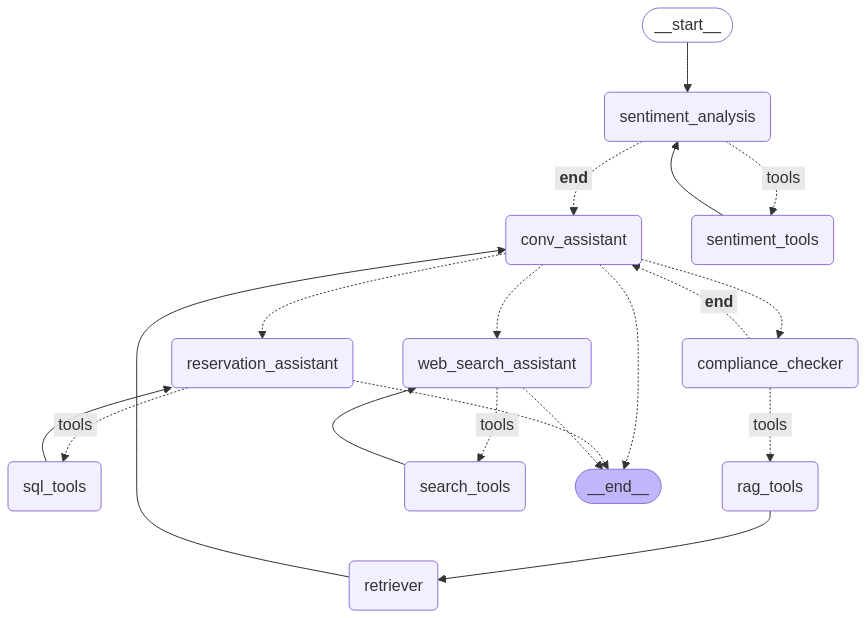

In [8]:
# Draw the graph
from IPython.display import Image, display
png = react_graph_with_memory.get_graph().draw_mermaid_png()
display(Image(png))

In [19]:
thread_id = 44 # Replace with the actual thread ID

# Example usage:
query = "Hallo, wie lange ist der Empfang heute geöffnet?"

events = react_graph_with_memory.stream({"messages": [HumanMessage(content=query)], "confidence": 100},
                                        config={"thread_id": thread_id},  # Pass the thread_id here
                                        stream_mode="values")

# iterate over the messages
for event in events:
    event["messages"][-1].pretty_print()
    message_content = event["messages"][-1].content
    if "Answer:" in message_content:
        final_answer = message_content.split("Answer:", 1)[1].strip()

================================ Human Message =================================

Hallo, wie lange ist der Empfang heute geöffnet?
content='Hallo, wie lange ist der Empfang heute geöffnet?' additional_kwargs={} response_metadata={} id='fb2b476c-fc67-45c7-8adb-368d855d50bd'
Hi


Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


{'english_version': 'Hello, how long is the reception open today?', 'original_version': 'Hallo, wie lange ist der Empfang heute geöffnet?', 'source_language': 'de'}
================================== Ai Message ==================================
Tool Calls:
  get_sentiment (call_bIXcvqp2IPTNSGu8hYRHIbbg)
 Call ID: call_bIXcvqp2IPTNSGu8hYRHIbbg
  Args:
    query: Hello, how long is the reception open today?
================================= Tool Message =================================
Name: get_sentiment

Positive
content='Positive' name='get_sentiment' id='7d076927-86ca-42f2-ab2e-4558e98a119c' tool_call_id='call_bIXcvqp2IPTNSGu8hYRHIbbg'
================================== Ai Message ==================================

Positive


Device set to use cpu


{'english_version': 'Hallo! Der Empfang ist heute bis 22:00 Uhr geöffnet. Wie kann ich Ihnen sonst noch behilflich sein?', 'original_version': 'Hallo! Der Empfang ist heute bis 22:00 Uhr geöffnet. Wie kann ich Ihnen sonst noch behilflich sein?', 'source_language': 'de'}
================================== Ai Message ==================================

Hallo! Der Empfang ist heute bis 22:00 Uhr geöffnet. Wie kann ich Ihnen sonst noch behilflich sein?
